# Vector Quantised Variational AutoEncoder (VQ-VAE)

VQ-VAE, [arXiv:1711.00937 [cs.LG]](https://arxiv.org/abs/1711.00937)

VQ-VAE-2, [arXiv:1906.00446 [cs.LG]](https://arxiv.org/abs/1906.00446)

Encoder output is $q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})$. We have a codebook consisting of $K$ embedding vectors $\boldsymbol{e}_{j}\in R^{D}$, $j=1,2,\ldots,K$. Posterior categorical distribution of discrete latent variables is
$$
q(k|\boldsymbol{x})=\delta_{k,k^{*}}\,,
$$
where
$$
k^{*}=\mathrm{argmin}_{j}\left\Vert q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})-\boldsymbol{e}_{j}\right\Vert _{2}\,.
$$
Prior distribution $p(k)=\frac{1}{K}$. The Kullback-Leibler divergence is constant:
$$
D_{\mathrm{KL}}(q(k|\boldsymbol{x})||p(k))=\sum_{k=1}^{K}q(k|\boldsymbol{x})\log\left(\frac{q(k|\boldsymbol{x})}{p(k)}\right)=-\log(p(k^{*}))=\log K\,.
$$
Decoder input is $\boldsymbol{z}_{q}=\boldsymbol{e}_{k^{*}}$, decoder output $p_{\boldsymbol{\theta}}(\boldsymbol{x}|\boldsymbol{z}_{q})$. During learning we copy the gradients from the decoder input $\boldsymbol{z}_{q}$
to the encoder output $q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})$. Total loss:
$$
\mathcal{L}=-\log p_{\boldsymbol{\theta}}(\boldsymbol{x}|\boldsymbol{z}_{q})
+\left\Vert \mathrm{sg}[q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})]-\boldsymbol{e}_{k^{*}}\right\Vert _{2}^{2}
+\beta\left\Vert q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})-\mathrm{sg}[\boldsymbol{e}_{k^{*}}]\right\Vert _{2}^{2}\,.
$$
Here $\mathrm{sg}[\cdot]$ is the stopgradient operator. The first term is the reconstruction loss, the second is the codebook loss, the third term is the commitment loss.

Instead of embedding loss we can set the embedding vectors to the moving averages of encoder outputs $q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})$
that are closest to the embedding vector.

## Configuration

Imports

In [1]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vision_utils

Configuration

In [2]:
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")

NUM_WORKERS = 8
BATCH_SIZE = 128

IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
ENCODER_CHANNELS = 16
LATENT_CHANNELS = 16
NUM_DOWNSAMPLINGS = 5
NUM_EMBEDDINGS = 256

EPOCHS = 20
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

### Vector Quantizer

From https://github.com/AntixK/PyTorch-VAE/blob/master/models/vq_vae.py and https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost = 0.25):
        super().__init__()
        self.commitment_cost = commitment_cost
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.reset_parameters()

    def forward(self, latents):
        # Compute L2 distances between latents and embedding weights
        dist = torch.linalg.vector_norm(latents.movedim(1, -1).unsqueeze(-2) - self.embedding.weight, dim=-1)
        encoding_inds = torch.argmin(dist, dim=-1)        # Get the number of the nearest codebook vector
        quantized_latents = self.quantize(encoding_inds)  # Quantize the latents

        # Compute the VQ Losses
        codebook_loss = F.mse_loss(latents.detach(), quantized_latents)
        commitment_loss = F.mse_loss(latents, quantized_latents.detach())
        vq_loss = codebook_loss + self.commitment_cost * commitment_loss

        # Make the gradient with respect to latents be equal to the gradient with respect to quantized latents 
        quantized_latents = latents + (quantized_latents - latents).detach()
        return quantized_latents, vq_loss
    
    def quantize(self, encoding_indices):
        z = self.embedding(encoding_indices)
        z = z.movedim(-1, 1) # Move channels back
        return z
    
    def reset_parameters(self):
        nn.init.uniform_(self.embedding.weight, -1 / self.num_embeddings, 1 / self.num_embeddings)

### Utilities

In [5]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self[0].weight)
        bn = self[1]
        nn.init.ones_(bn.weight)
        nn.init.zeros_(bn.bias)

In [6]:
class Stack(nn.Sequential):
    def __init__(self, channels_list, block):
        layers = []
        for in_channels, out_channels in zip(channels_list[:-1], channels_list[1:]):
            layers.append(block(in_channels, out_channels))
        super().__init__(*layers)

### Encoder

In [7]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, 3)
        )

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, channels_list, latent_channels):
        super().__init__()
        self.stem = ConvBlock(in_channels, channels_list[0], 3)
        self.blocks = Stack(channels_list, DownBlock)
        self.to_latent = ConvBlock(channels_list[-1], latent_channels, 3)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.to_latent(x)
        return x

### Decoder

In [9]:
class UpBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ConvBlock(in_channels, out_channels, 3)
        )

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_channels, channels_list, out_channels):
        super().__init__()
        self.stem = ConvBlock(latent_channels, channels_list[0], 3)
        self.blocks = Stack(channels_list, UpBlock)
        self.to_output = nn.Conv2d(channels_list[-1], out_channels, 3, padding=1)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.to_output(x)
        x = torch.sigmoid(x)
        return x

### VQ-VAE

In [11]:
class VQVAE(nn.Module):
    def __init__(self, num_downsamplings, latent_channels, num_embeddings, channels=32, in_channels=3):
        super().__init__()
        channels_list = [channels * 2**i for i in range(num_downsamplings + 1)]
        self.encoder = Encoder(in_channels, channels_list, latent_channels)
        self.vq = VectorQuantizer(num_embeddings, latent_channels)
        channels_list.reverse()
        self.decoder = Decoder(latent_channels, channels_list, in_channels)
        self.reduction = 2**num_downsamplings
        self.num_embeddings = num_embeddings
    
    def forward(self, x):
        latents = self.encoder(x)
        z, vq_loss = self.vq(latents)
        out = self.decoder(z)
        return out, vq_loss
    
    def sample(self, num_samples, shape, device):
        latent_shape = (num_samples, shape[0] // self.reduction, shape[1] // self. reduction)
        ind = torch.randint(0, self.num_embeddings, latent_shape, device=device)
        with torch.no_grad():
            z = self.vq.quantize(ind)
            out = self.decoder(z)
        return out

### Model creation

In [12]:
model = VQVAE(num_downsamplings=NUM_DOWNSAMPLINGS, latent_channels=LATENT_CHANNELS, num_embeddings=NUM_EMBEDDINGS,
              channels=ENCODER_CHANNELS, in_channels=IMAGE_CHANNELS)

In [13]:
model = model.to(DEVICE)

In [14]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 3,299,139


## Loss

In [15]:
class VAELoss(nn.Module):
    def __init__(self, λ=1.):
        super().__init__()
        self.λ = λ
        self.reconstruction_loss = nn.MSELoss()
    
    def forward(self, outputs, target):
        output, vq_loss = outputs
        reconst_loss = self.reconstruction_loss(output, target)
        
        loss = reconst_loss + self.λ * vq_loss
        return {"loss": loss, "reconstruction loss": reconst_loss, "VQ loss": vq_loss}

## Utilities

In [16]:
def plot_batch(ax, batch, title=None, **kwargs):
    imgs = vision_utils.make_grid(batch, padding=2, normalize=True)
    imgs = np.moveaxis(imgs.numpy(), 0, -1)
    ax.set_axis_off()
    if title is not None: ax.set_title(title)
    return ax.imshow(imgs, **kwargs)

In [17]:
def show_images(batch, title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plot_batch(ax, batch, title)
    plt.show()

In [18]:
def reconstruct(model, batch, device):
    batch = batch.to(device)
    with torch.no_grad():
        reconstructed_batch = model(batch)[0]
    reconstructed_batch = reconstructed_batch.cpu()
    return reconstructed_batch

In [19]:
def show_2_batches(batch1, batch2, title1, title2):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121)
    plot_batch(ax, batch1, title1)

    ax = fig.add_subplot(122)
    plot_batch(ax, batch2, title2)
    plt.show()

## Data

In [20]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [21]:
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

In [22]:
train_dset = datasets.CelebA(str(DATA_DIR), split='train', transform=train_transform, download=False)
val_dset = datasets.CelebA(str(DATA_DIR), split='test', transform=val_transform, download=False)

In [23]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS)

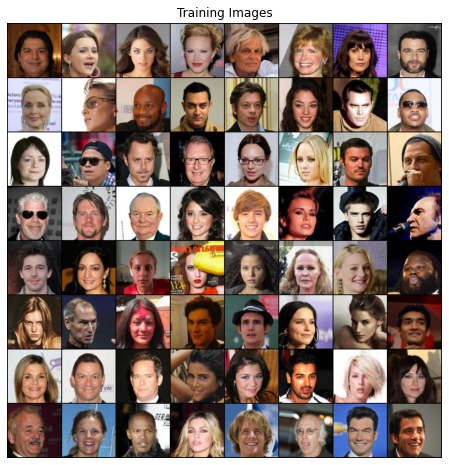

In [24]:
test_batch, _ = next(iter(train_loader))
show_images(test_batch[:64], "Training Images")

## Training

### Learner

In [25]:
class AverageLoss():
    def __init__(self, name):
        self.name = name
        self.reset()
    
    def reset(self):
        self.num_samples = 0
        self.total_loss = 0.
    
    def update(self, data):
        batch_size = data['batch_size']
        self.num_samples += batch_size
        self.total_loss += batch_size * data[self.name]
        
    def compute(self):
        avg_loss = self.total_loss / self.num_samples
        metrics = {self.name: avg_loss}
        return metrics

In [26]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 batch_scheduler=None, epoch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.batch_scheduler = batch_scheduler
        self.epoch_scheduler = epoch_scheduler
        self.history = defaultdict(list)
        self.metrics = [AverageLoss(x) for x in ["loss", "reconstruction loss", "VQ loss"]]
    
    def iterate(self, loader, train=False):
        for metric in self.metrics:
            metric.reset()
        
        for batch in loader:
            images = batch[0].to(self.device)
            outputs = self.model(images)
            losses = self.loss(outputs, images)
            
            if train: self.backward_pass(losses["loss"])
            
            data = {k: v.item() for k, v in losses.items()}
            data["batch_size"] = len(images)
            
            for metric in self.metrics:
                metric.update(data)
        
        summary = {}
        for metric in self.metrics:
            summary.update(metric.compute())
        return summary
    
    def backward_pass(self, batch_loss):
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()

        if self.batch_scheduler is not None:
            self.batch_scheduler.step()
    
    def log_metrics(self, metrics, name):
        print(f"{name}: ", end='', flush=True)
        for key, val in metrics.items():
            self.history[name + ' ' + key].append(val)
            print(f"{key} {val:.3f} ", end='')
    
    def train(self):
        self.model.train()
        metrics = self.iterate(self.train_loader, train=True)
        self.log_metrics(metrics, 'train')
    
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            metrics = self.iterate(self.val_loader)
        self.log_metrics(metrics, 'val')
    
    def fit(self, epochs):
        for epoch in range(1, epochs + 1):
            print(f"{epoch}/{epochs} - ", end='')
            self.train()
            print('; ', end='')
            self.validate()
            print()
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()
        
        torch.save(model.state_dict(), str(MODELS_DIR / 'final_model.pt'))

In [27]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    ax.legend()
    plt.show()

### Start training

In [28]:
loss = VAELoss(λ=0.1)

In [29]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [30]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [31]:
learner = Learner(model, loss, optimizer, train_loader, val_loader, DEVICE, batch_scheduler=lr_scheduler)

In [32]:
learner.fit(EPOCHS)

1/20 - train: loss 0.126 reconstruction loss 0.036 VQ loss 0.896 ; val: loss 0.054 reconstruction loss 0.021 VQ loss 0.327 
2/20 - train: loss 0.035 reconstruction loss 0.018 VQ loss 0.169 ; val: loss 0.027 reconstruction loss 0.016 VQ loss 0.108 
3/20 - train: loss 0.024 reconstruction loss 0.015 VQ loss 0.095 ; val: loss 0.023 reconstruction loss 0.014 VQ loss 0.087 
4/20 - train: loss 0.021 reconstruction loss 0.013 VQ loss 0.077 ; val: loss 0.020 reconstruction loss 0.012 VQ loss 0.072 
5/20 - train: loss 0.020 reconstruction loss 0.013 VQ loss 0.072 ; val: loss 0.020 reconstruction loss 0.013 VQ loss 0.075 
6/20 - train: loss 0.020 reconstruction loss 0.012 VQ loss 0.078 ; val: loss 0.020 reconstruction loss 0.012 VQ loss 0.083 
7/20 - train: loss 0.020 reconstruction loss 0.012 VQ loss 0.085 ; val: loss 0.021 reconstruction loss 0.012 VQ loss 0.089 
8/20 - train: loss 0.021 reconstruction loss 0.012 VQ loss 0.090 ; val: loss 0.022 reconstruction loss 0.012 VQ loss 0.099 
9/20 - t

### Plotting

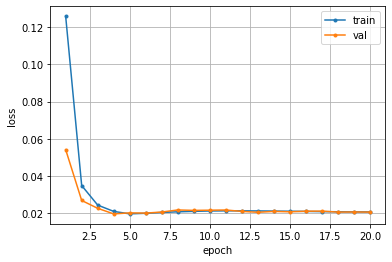

In [33]:
plot_history_train_val(learner.history, 'loss')

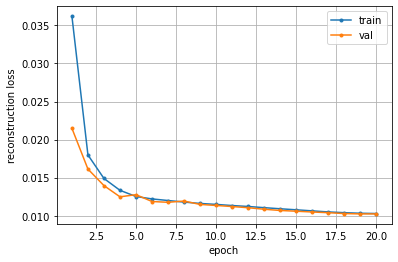

In [34]:
plot_history_train_val(learner.history, 'reconstruction loss')

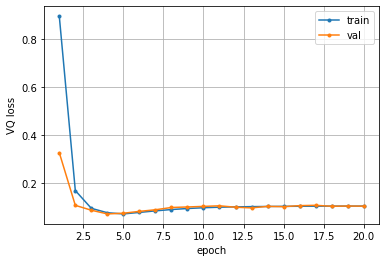

In [35]:
plot_history_train_val(learner.history, 'VQ loss')

## Testing

In [36]:
model.load_state_dict(torch.load(str(MODELS_DIR / 'final_model.pt')))

<All keys matched successfully>

In [37]:
model.eval();

Testing reconstruction

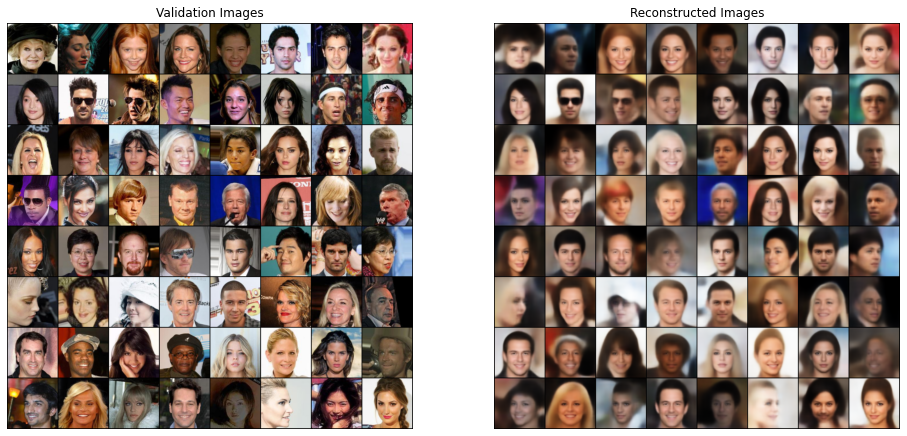

In [38]:
test_batch, _ = next(iter(val_loader))
reconstructed_batch = reconstruct(model, test_batch, DEVICE)
show_2_batches(test_batch[:64], reconstructed_batch[:64], "Validation Images", "Reconstructed Images")

Testing generation

In [39]:
sample_images = model.sample(64, (IMAGE_SIZE, IMAGE_SIZE), DEVICE)

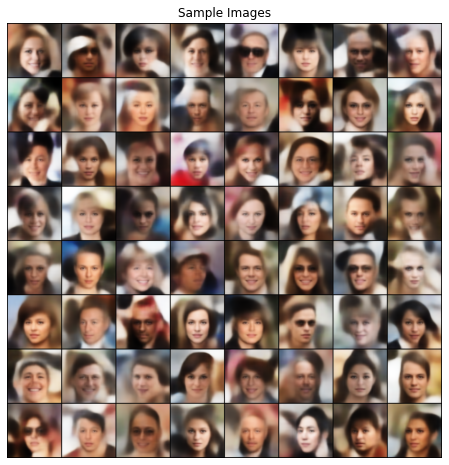

In [40]:
show_images(sample_images.cpu(), "Sample Images")